In [2]:
# example of defining a u-net encoder-decoder generator model
from __future__ import print_function
import os
import random
from random import randint
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
plt.style.use("grayscale")
%matplotlib inline
#%matplotlib notebook
import time

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from skimage import color

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.losses import mean_absolute_error,binary_crossentropy
import keras.backend as K

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

from keras.applications.vgg19 import VGG19
from keras.models import Model

from functions import *

Using TensorFlow backend.


In [3]:
def vgg_loss_inner(y_true, y_pred):
    vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(256,256,3))
    vgg19.trainable = False
    for l in vgg19.layers:
        l.trainable = False
    model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
    model.trainable = False
    
    return 10*K.mean(K.square(model(y_true) - model(y_pred)))

def vgg_obj(vgg_fact=1):
    def vgg_loss(y_true, y_pred):
        return K.abs(vgg_fact * vgg_loss_inner(y_true, y_pred) + (1-vgg_fact) * mean_absolute_error(y_true, y_pred))
    return vgg_loss

def ssim_metric(y_true, y_pred):
    batch_size = y_true.shape[0];
    ssim_sum = 0
    for i in range(batch_size):
        ssim_sum += tf.image.ssim_multiscale(y_true,y_pred,1)
    return ssim_sum/batch_size;


def ssim_tf(ssim_fact=1):
    def ssim_loss(y_true, y_pred):
        return K.abs(ssim_fact * (1-tf.image.ssim_multiscale(y_true,y_pred,1)) + (1-ssim_fact) * mean_absolute_error(y_true, y_pred))
    return ssim_loss

In [35]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape, loss_fact=0.5, loss_weights=[1,100]):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # ssim loss
    ssimTF = ssim_tf(ssim_fact=loss_fact)
    vggloss = vgg_obj(vgg_fact=loss_fact);
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', vggloss], optimizer=opt, loss_weights=loss_weights)
    return model

In [25]:
# train pix2pix models
def train(d_model, g_model, gan_model, train_crops, n_steps, n_batch, weight_name, dir_name=None):
    if dir_name is None:
        dir_name = weight_name
    # number of iter to save state
    save_num = 200
    # size of descriminator return - 16x16
    n_patch=16
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    # init tmp vars
    g_loss_min = 100;
    d1 = []; d2 = []; g1 = []; g2 = []; g3 = [];
    ds1 = 0; ds2 = 0; gs1 = 0; gs2 = 0; gs3 = 0;
    # manually enumerate epochs
    for i in range(n_steps):
        start_time = time.time()
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(train_crops, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_total, g_cross, g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # save tmp learning losses
        ds1 += d_loss1; ds2 += d_loss2; gs1 += g_total; gs2 += g_cross; gs3 += g_loss;
        print('%d, d_real[%.3f] d_fake[%.3f] g_total[%.3f] g_cross[%.3f] g_loss[%.3f] %.3f[sec]' % (i, d_loss1, d_loss2, g_total, g_cross, g_loss, time.time()-start_time))
        # save best params
        if i % 10 == 0:
            d1.append(ds1/10);d2.append(ds2/10);g1.append(gs1/10);g2.append(gs2/10);g3.append(gs3/10);
            ds1 = 0; ds2 = 0; gs1 = 0; gs2 = 0; gs3 = 0;
            if g_loss < g_loss_min:
                g_model.save_weights(dir_name+'/g_model_best_loss_' + weight_name + '.h5')
                g_loss_min = g_loss
                print('best loss model saved!')
        # save elaps params        
        if i % save_num == 0:
            g_model.save_weights(dir_name+'/g_model_' + weight_name + '.h5')
            d_model.save_weights(dir_name+'/d_model_' + weight_name + '.h5')
            print('model saved...')
    
    g_model.save_weights(dir_name+'/g_model_' + weight_name + '.h5')
    d_model.save_weights(dir_name+'/d_model_' + weight_name + '.h5')
    return d1, d2, g1, g2, g3

In [8]:
def scedual_trainings():
    # define image shape
    t_image_shape = (256,256,1);c_image_shape = (256,256,3)
    # define the models
    batch_size = 8
    data_gen_args = dict(horizontal_flip=True)
    image_datagen = ImageDataGenerator(**data_gen_args)        
    yimage_generator = image_datagen.flow(y_train, seed=2019, batch_size=batch_size, shuffle=True)
    Ximage_generator = image_datagen.flow(X_train, seed=2019, batch_size=batch_size, shuffle=True)
    train_generator = zip(Ximage_generator, yimage_generator)
    train_crops = crop_generator(train_generator, 256, rand_crop=True)
    dir_name = 'schedualer_20.11'
    #1
    K.clear_session()
    weight_name = 'L1_(1,300)w_60e3iter_8b'
    weight_name_saved = 'L1_(1,300)w_30e3iter_8b'
    d_model = define_discriminator(t_image_shape, c_image_shape)
    g_model = define_generator(t_image_shape)
    g_model.load_weights(dir_name+'/g_model_' + weight_name_saved + '.h5')
    d_model.load_weights(dir_name+'/d_model_' + weight_name_saved + '.h5')
    gan_model = define_gan(g_model, d_model, t_image_shape, loss_fact=1, loss_weights=[1,300])
    loss1 = train(d_model, g_model, gan_model, train_crops, 30000, batch_size, weight_name=weight_name, dir_name=dir_name)
    save(loss1, dir_name+'/loss__'+weight_name)
    #1
    K.clear_session()
    weight_name = 'L1_(1,600)w_60e3iter_8b'
    weight_name_saved = 'L1_(1,600)w_30e3iter_8b'
    d_model = define_discriminator(t_image_shape, c_image_shape)
    g_model = define_generator(t_image_shape)
    g_model.load_weights(dir_name+'/g_model_' + weight_name_saved + '.h5')
    d_model.load_weights(dir_name+'/d_model_' + weight_name_saved + '.h5')
    gan_model = define_gan(g_model, d_model, t_image_shape, loss_fact=1, loss_weights=[1,600])
    loss1 = train(d_model, g_model, gan_model, train_crops, 30000, batch_size, weight_name=weight_name, dir_name=dir_name)
    save(loss1, dir_name+'/loss__'+weight_name)
    #1
    K.clear_session()
    weight_name = 'L1_(1,800)w_60e3iter_8b'
    weight_name_saved = 'L1_(1,800)w_30e3iter_8b'
    d_model = define_discriminator(t_image_shape, c_image_shape)
    g_model = define_generator(t_image_shape)
    g_model.load_weights(dir_name+'/g_model_' + weight_name_saved + '.h5')
    d_model.load_weights(dir_name+'/d_model_' + weight_name_saved + '.h5')
    gan_model = define_gan(g_model, d_model, t_image_shape, loss_fact=1, loss_weights=[1,800])
    loss1 = train(d_model, g_model, gan_model, train_crops, 30000, batch_size, weight_name=weight_name, dir_name=dir_name)
    save(loss1, dir_name+'/loss__'+weight_name)
    #1
    K.clear_session()
    weight_name = 'L1_(1,1200)w_60e3iter_8b'
    weight_name_saved = 'L1_(1,1200)w_30e3iter_8b'
    d_model = define_discriminator(t_image_shape, c_image_shape)
    g_model = define_generator(t_image_shape)
    g_model.load_weights(dir_name+'/g_model_' + weight_name_saved + '.h5')
    d_model.load_weights(dir_name+'/d_model_' + weight_name_saved + '.h5')
    gan_model = define_gan(g_model, d_model, t_image_shape, loss_fact=1, loss_weights=[1,1200])
    loss1 = train(d_model, g_model, gan_model, train_crops, 30000, batch_size, weight_name=weight_name, dir_name=dir_name)
    save(loss1, dir_name+'/loss__'+weight_name)
    #1
    K.clear_session()
    weight_name = 'L1_(1,1400)w_60e3iter_8b'
    weight_name_saved = 'L1_(1,1400)w_30e3iter_8b'
    d_model = define_discriminator(t_image_shape, c_image_shape)
    g_model = define_generator(t_image_shape)
    g_model.load_weights(dir_name+'/g_model_' + weight_name_saved + '.h5')
    d_model.load_weights(dir_name+'/d_model_' + weight_name_saved + '.h5')
    gan_model = define_gan(g_model, d_model, t_image_shape, loss_fact=1, loss_weights=[1,1400])
    loss1 = train(d_model, g_model, gan_model, train_crops, 30000, batch_size, weight_name=weight_name, dir_name=dir_name)
    save(loss1, dir_name+'/loss__'+weight_name)

In [9]:
im_width = 640; im_height = 512
border = 5
path_train = '../../../data/FLIR/training/Calib_cut/'
# path_train = '/home/nvs/Documents/DB/FLIR/Calib/Sample2/'
#path_train = '/home/nadav.shalev/Desktop/Calib/'
X,Y = get_data(path_train, im_height, im_width)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=16/1040,random_state=2019)

/opt/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [36]:
K.clear_session()
weight_name = 'discOnly'
dir_name = 'train26.11'
# define image shape
t_image_shape = (256,256,1);c_image_shape = (256,256,3)
# define the models
# weight_name = 'vgg1_(1,1000)2.8e3iter_8b'
d_model = define_discriminator(t_image_shape, c_image_shape)
g_model = define_generator(t_image_shape)
# g_model.load_weights(dir_name+'/g_model_' + weight_name + '.h5')
# d_model.load_weights(dir_name+'/d_model_' + weight_name + '.h5')

# define the composite model
gan_model = define_gan(g_model, d_model, t_image_shape,loss_fact=1, loss_weights=[1,0])

# summarize the model
# gan_model.summary()
# plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)
batch_size = 8
data_gen_args = dict(horizontal_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)        
yimage_generator = image_datagen.flow(y_train, seed=2019, batch_size=batch_size, shuffle=True)
Ximage_generator = image_datagen.flow(X_train, seed=2019, batch_size=batch_size, shuffle=True)
train_generator = zip(Ximage_generator, yimage_generator)
train_crops = crop_generator(train_generator, 256, rand_crop=False)

In [37]:
s = train(d_model, g_model, gan_model, train_crops, 1000, batch_size, weight_name=weight_name, dir_name=dir_name)
save(s, dir_name+'/loss__'+weight_name)

0, d_real[0.219] d_fake[1.034] g_total[2.317] g_cross[2.317] g_loss[0.372] 7.823[sec]
best loss model saved!
model saved...
1, d_real[0.816] d_fake[0.792] g_total[1.526] g_cross[1.526] g_loss[0.340] 0.496[sec]
2, d_real[0.499] d_fake[0.611] g_total[1.329] g_cross[1.329] g_loss[0.314] 0.492[sec]
3, d_real[0.252] d_fake[0.679] g_total[1.039] g_cross[1.039] g_loss[0.318] 0.492[sec]
4, d_real[0.184] d_fake[0.543] g_total[1.358] g_cross[1.358] g_loss[0.397] 0.499[sec]
5, d_real[0.169] d_fake[0.419] g_total[1.339] g_cross[1.339] g_loss[0.388] 0.495[sec]
6, d_real[0.217] d_fake[0.337] g_total[1.416] g_cross[1.416] g_loss[0.390] 0.496[sec]
7, d_real[0.217] d_fake[0.432] g_total[1.461] g_cross[1.461] g_loss[0.383] 0.496[sec]
8, d_real[0.140] d_fake[0.333] g_total[1.411] g_cross[1.411] g_loss[0.301] 0.495[sec]
9, d_real[0.185] d_fake[0.269] g_total[1.497] g_cross[1.497] g_loss[0.400] 0.490[sec]
10, d_real[0.281] d_fake[0.338] g_total[1.774] g_cross[1.774] g_loss[0.379] 0.529[sec]
11, d_real[0.18

94, d_real[0.421] d_fake[0.327] g_total[1.750] g_cross[1.750] g_loss[0.307] 0.493[sec]
95, d_real[0.328] d_fake[0.326] g_total[1.767] g_cross[1.767] g_loss[0.310] 0.486[sec]
96, d_real[0.331] d_fake[0.354] g_total[1.906] g_cross[1.906] g_loss[0.241] 0.497[sec]
97, d_real[0.398] d_fake[0.300] g_total[2.151] g_cross[2.151] g_loss[0.281] 0.502[sec]
98, d_real[0.432] d_fake[0.420] g_total[1.600] g_cross[1.600] g_loss[0.349] 0.498[sec]
99, d_real[0.369] d_fake[0.285] g_total[1.555] g_cross[1.555] g_loss[0.307] 0.503[sec]
100, d_real[0.334] d_fake[0.361] g_total[1.472] g_cross[1.472] g_loss[0.260] 0.497[sec]
best loss model saved!
101, d_real[0.339] d_fake[0.285] g_total[1.558] g_cross[1.558] g_loss[0.356] 0.537[sec]
102, d_real[0.254] d_fake[0.298] g_total[1.708] g_cross[1.708] g_loss[0.306] 0.497[sec]
103, d_real[0.288] d_fake[0.319] g_total[1.603] g_cross[1.603] g_loss[0.350] 0.497[sec]
104, d_real[0.273] d_fake[0.331] g_total[2.093] g_cross[2.093] g_loss[0.327] 0.499[sec]
105, d_real[0.3

187, d_real[0.768] d_fake[0.280] g_total[1.746] g_cross[1.746] g_loss[0.317] 0.505[sec]
188, d_real[0.256] d_fake[0.444] g_total[1.745] g_cross[1.745] g_loss[0.374] 0.506[sec]
189, d_real[0.235] d_fake[0.268] g_total[2.027] g_cross[2.027] g_loss[0.305] 0.514[sec]
190, d_real[0.269] d_fake[0.187] g_total[2.152] g_cross[2.152] g_loss[0.253] 0.511[sec]
191, d_real[0.417] d_fake[0.207] g_total[1.948] g_cross[1.948] g_loss[0.239] 0.507[sec]
192, d_real[0.209] d_fake[0.446] g_total[2.095] g_cross[2.095] g_loss[0.259] 0.498[sec]
193, d_real[0.291] d_fake[0.202] g_total[1.965] g_cross[1.965] g_loss[0.288] 0.496[sec]
194, d_real[0.235] d_fake[0.296] g_total[1.875] g_cross[1.875] g_loss[0.343] 0.494[sec]
195, d_real[0.283] d_fake[0.223] g_total[1.986] g_cross[1.986] g_loss[0.324] 0.509[sec]
196, d_real[0.235] d_fake[0.300] g_total[2.279] g_cross[2.279] g_loss[0.219] 0.503[sec]
197, d_real[0.363] d_fake[0.318] g_total[1.861] g_cross[1.861] g_loss[0.334] 0.501[sec]
198, d_real[0.351] d_fake[0.362]

280, d_real[0.277] d_fake[0.289] g_total[1.934] g_cross[1.934] g_loss[0.245] 0.498[sec]
281, d_real[0.340] d_fake[0.430] g_total[2.030] g_cross[2.030] g_loss[0.306] 0.482[sec]
282, d_real[0.305] d_fake[0.137] g_total[1.952] g_cross[1.952] g_loss[0.318] 0.486[sec]
283, d_real[0.268] d_fake[0.385] g_total[1.688] g_cross[1.688] g_loss[0.300] 0.493[sec]
284, d_real[0.143] d_fake[0.291] g_total[2.043] g_cross[2.043] g_loss[0.299] 0.488[sec]
285, d_real[0.375] d_fake[0.167] g_total[1.955] g_cross[1.955] g_loss[0.277] 0.486[sec]
286, d_real[0.288] d_fake[0.270] g_total[1.898] g_cross[1.898] g_loss[0.365] 0.481[sec]
287, d_real[0.160] d_fake[0.268] g_total[1.991] g_cross[1.991] g_loss[0.370] 0.489[sec]
288, d_real[0.345] d_fake[0.397] g_total[2.345] g_cross[2.345] g_loss[0.330] 0.483[sec]
289, d_real[0.445] d_fake[0.276] g_total[1.941] g_cross[1.941] g_loss[0.316] 0.492[sec]
290, d_real[0.244] d_fake[0.306] g_total[1.947] g_cross[1.947] g_loss[0.324] 0.496[sec]
291, d_real[0.213] d_fake[0.170]

374, d_real[0.534] d_fake[0.444] g_total[2.127] g_cross[2.127] g_loss[0.282] 0.491[sec]
375, d_real[0.410] d_fake[0.502] g_total[1.860] g_cross[1.860] g_loss[0.343] 0.485[sec]
376, d_real[0.391] d_fake[0.169] g_total[2.340] g_cross[2.340] g_loss[0.262] 0.486[sec]
377, d_real[0.226] d_fake[0.214] g_total[2.335] g_cross[2.335] g_loss[0.276] 0.485[sec]
378, d_real[0.256] d_fake[0.392] g_total[2.179] g_cross[2.179] g_loss[0.216] 0.493[sec]
379, d_real[0.238] d_fake[0.141] g_total[2.236] g_cross[2.236] g_loss[0.284] 0.488[sec]
380, d_real[0.231] d_fake[0.506] g_total[2.157] g_cross[2.157] g_loss[0.292] 0.492[sec]
381, d_real[0.373] d_fake[0.188] g_total[1.994] g_cross[1.994] g_loss[0.278] 0.489[sec]
382, d_real[0.221] d_fake[0.527] g_total[2.240] g_cross[2.240] g_loss[0.316] 0.492[sec]
383, d_real[0.416] d_fake[0.234] g_total[2.265] g_cross[2.265] g_loss[0.299] 0.490[sec]
384, d_real[0.253] d_fake[0.203] g_total[2.313] g_cross[2.313] g_loss[0.354] 0.483[sec]
385, d_real[0.199] d_fake[0.225]

467, d_real[0.213] d_fake[0.376] g_total[1.835] g_cross[1.835] g_loss[0.284] 0.493[sec]
468, d_real[0.365] d_fake[0.381] g_total[2.311] g_cross[2.311] g_loss[0.274] 0.483[sec]
469, d_real[0.533] d_fake[0.343] g_total[1.785] g_cross[1.785] g_loss[0.279] 0.491[sec]
470, d_real[0.306] d_fake[0.206] g_total[1.952] g_cross[1.952] g_loss[0.233] 0.487[sec]
best loss model saved!
471, d_real[0.185] d_fake[0.256] g_total[2.213] g_cross[2.213] g_loss[0.246] 0.490[sec]
472, d_real[0.219] d_fake[0.169] g_total[2.087] g_cross[2.087] g_loss[0.235] 0.483[sec]
473, d_real[0.204] d_fake[0.280] g_total[2.445] g_cross[2.445] g_loss[0.247] 0.514[sec]
474, d_real[0.316] d_fake[0.235] g_total[1.966] g_cross[1.966] g_loss[0.210] 0.492[sec]
475, d_real[0.176] d_fake[0.168] g_total[2.262] g_cross[2.262] g_loss[0.326] 0.486[sec]
476, d_real[0.206] d_fake[0.177] g_total[2.215] g_cross[2.215] g_loss[0.269] 0.489[sec]
477, d_real[0.206] d_fake[0.136] g_total[2.439] g_cross[2.439] g_loss[0.245] 0.488[sec]
478, d_re

560, d_real[0.084] d_fake[0.116] g_total[3.679] g_cross[3.679] g_loss[0.305] 0.490[sec]
561, d_real[0.125] d_fake[0.073] g_total[4.257] g_cross[4.257] g_loss[0.295] 0.484[sec]
562, d_real[0.113] d_fake[0.130] g_total[3.421] g_cross[3.421] g_loss[0.332] 0.484[sec]
563, d_real[0.093] d_fake[0.053] g_total[4.128] g_cross[4.128] g_loss[0.298] 0.485[sec]
564, d_real[0.047] d_fake[0.069] g_total[3.988] g_cross[3.988] g_loss[0.275] 0.483[sec]
565, d_real[0.086] d_fake[0.209] g_total[4.077] g_cross[4.077] g_loss[0.239] 0.492[sec]
566, d_real[0.130] d_fake[0.183] g_total[5.164] g_cross[5.164] g_loss[0.239] 0.492[sec]
567, d_real[0.293] d_fake[0.074] g_total[3.207] g_cross[3.207] g_loss[0.302] 0.494[sec]
568, d_real[0.067] d_fake[0.141] g_total[4.345] g_cross[4.345] g_loss[0.229] 0.488[sec]
569, d_real[0.160] d_fake[0.044] g_total[3.344] g_cross[3.344] g_loss[0.272] 0.482[sec]
570, d_real[0.054] d_fake[0.211] g_total[4.436] g_cross[4.436] g_loss[0.233] 0.484[sec]
571, d_real[0.175] d_fake[0.048]

653, d_real[0.077] d_fake[0.041] g_total[3.452] g_cross[3.452] g_loss[0.302] 0.484[sec]
654, d_real[0.094] d_fake[0.229] g_total[4.391] g_cross[4.391] g_loss[0.317] 0.496[sec]
655, d_real[0.182] d_fake[0.127] g_total[4.008] g_cross[4.008] g_loss[0.319] 0.491[sec]
656, d_real[0.262] d_fake[0.139] g_total[3.391] g_cross[3.391] g_loss[0.349] 0.502[sec]
657, d_real[0.055] d_fake[0.069] g_total[3.747] g_cross[3.747] g_loss[0.330] 0.490[sec]
658, d_real[0.095] d_fake[0.140] g_total[3.987] g_cross[3.987] g_loss[0.353] 0.484[sec]
659, d_real[0.194] d_fake[0.208] g_total[4.069] g_cross[4.069] g_loss[0.313] 0.491[sec]
660, d_real[0.174] d_fake[0.064] g_total[3.600] g_cross[3.600] g_loss[0.316] 0.492[sec]
661, d_real[0.066] d_fake[0.190] g_total[4.091] g_cross[4.091] g_loss[0.328] 0.495[sec]
662, d_real[0.166] d_fake[0.098] g_total[3.404] g_cross[3.404] g_loss[0.330] 0.492[sec]
663, d_real[0.142] d_fake[0.239] g_total[4.675] g_cross[4.675] g_loss[0.290] 0.480[sec]
664, d_real[0.184] d_fake[0.158]

747, d_real[0.097] d_fake[0.016] g_total[4.336] g_cross[4.336] g_loss[0.274] 0.482[sec]
748, d_real[0.047] d_fake[0.040] g_total[3.834] g_cross[3.834] g_loss[0.353] 0.488[sec]
749, d_real[0.030] d_fake[0.111] g_total[4.248] g_cross[4.248] g_loss[0.295] 0.484[sec]
750, d_real[0.062] d_fake[0.088] g_total[3.976] g_cross[3.976] g_loss[0.267] 0.487[sec]
751, d_real[0.115] d_fake[0.052] g_total[3.738] g_cross[3.738] g_loss[0.342] 0.483[sec]
752, d_real[0.049] d_fake[0.246] g_total[5.620] g_cross[5.620] g_loss[0.360] 0.484[sec]
753, d_real[0.582] d_fake[0.075] g_total[3.149] g_cross[3.149] g_loss[0.268] 0.483[sec]
754, d_real[0.034] d_fake[0.322] g_total[4.323] g_cross[4.323] g_loss[0.326] 0.489[sec]
755, d_real[0.075] d_fake[0.049] g_total[4.884] g_cross[4.884] g_loss[0.294] 0.491[sec]
756, d_real[0.059] d_fake[0.030] g_total[4.264] g_cross[4.264] g_loss[0.325] 0.498[sec]
757, d_real[0.077] d_fake[0.044] g_total[3.672] g_cross[3.672] g_loss[0.347] 0.484[sec]
758, d_real[0.020] d_fake[0.209]

840, d_real[0.073] d_fake[0.045] g_total[3.727] g_cross[3.727] g_loss[0.220] 0.501[sec]
best loss model saved!
841, d_real[0.077] d_fake[0.114] g_total[4.075] g_cross[4.075] g_loss[0.271] 0.489[sec]
842, d_real[0.088] d_fake[0.086] g_total[4.292] g_cross[4.292] g_loss[0.307] 0.474[sec]
843, d_real[0.107] d_fake[0.248] g_total[5.700] g_cross[5.700] g_loss[0.321] 0.474[sec]
844, d_real[0.663] d_fake[0.041] g_total[2.711] g_cross[2.711] g_loss[0.271] 0.484[sec]
845, d_real[0.039] d_fake[0.405] g_total[5.498] g_cross[5.498] g_loss[0.247] 0.487[sec]
846, d_real[0.627] d_fake[0.367] g_total[3.916] g_cross[3.916] g_loss[0.293] 0.490[sec]
847, d_real[0.048] d_fake[0.065] g_total[3.879] g_cross[3.879] g_loss[0.309] 0.490[sec]
848, d_real[0.128] d_fake[0.154] g_total[3.372] g_cross[3.372] g_loss[0.265] 0.491[sec]
849, d_real[0.042] d_fake[0.100] g_total[3.943] g_cross[3.943] g_loss[0.287] 0.490[sec]
850, d_real[0.134] d_fake[0.142] g_total[3.711] g_cross[3.711] g_loss[0.226] 0.488[sec]
851, d_re

933, d_real[0.123] d_fake[0.487] g_total[5.728] g_cross[5.728] g_loss[0.298] 0.532[sec]
934, d_real[0.712] d_fake[0.053] g_total[2.623] g_cross[2.623] g_loss[0.311] 0.524[sec]
935, d_real[0.042] d_fake[0.366] g_total[4.309] g_cross[4.309] g_loss[0.322] 0.489[sec]
936, d_real[0.152] d_fake[0.030] g_total[3.746] g_cross[3.746] g_loss[0.265] 0.497[sec]
937, d_real[0.100] d_fake[0.098] g_total[3.350] g_cross[3.350] g_loss[0.269] 0.488[sec]
938, d_real[0.040] d_fake[0.114] g_total[3.788] g_cross[3.788] g_loss[0.267] 0.485[sec]
939, d_real[0.176] d_fake[0.328] g_total[4.528] g_cross[4.528] g_loss[0.254] 0.497[sec]
940, d_real[0.416] d_fake[0.149] g_total[3.397] g_cross[3.397] g_loss[0.261] 0.504[sec]
941, d_real[0.058] d_fake[0.142] g_total[3.124] g_cross[3.124] g_loss[0.292] 0.491[sec]
942, d_real[0.180] d_fake[0.256] g_total[5.620] g_cross[5.620] g_loss[0.338] 0.499[sec]
943, d_real[0.121] d_fake[0.063] g_total[5.152] g_cross[5.152] g_loss[0.261] 0.486[sec]
944, d_real[0.112] d_fake[0.206]

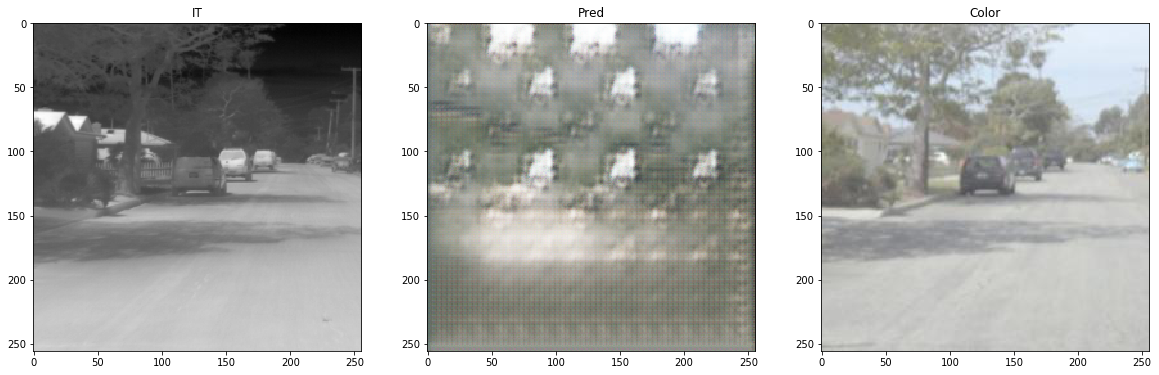

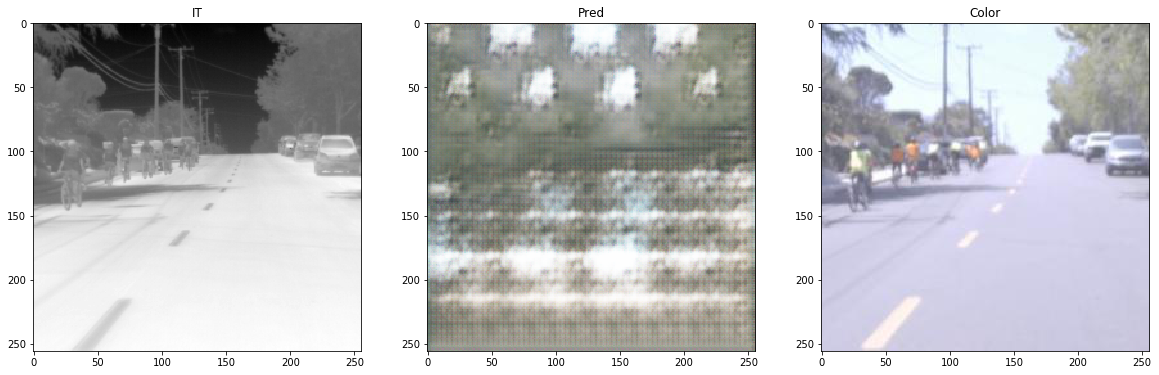

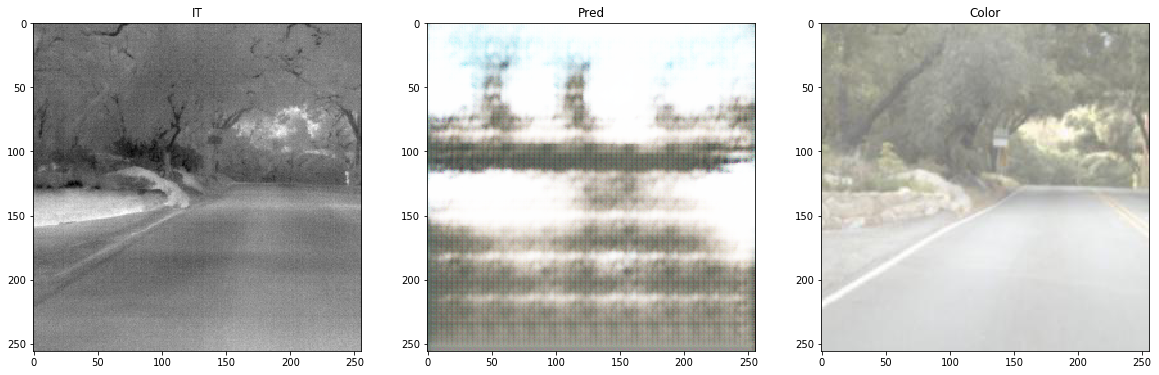

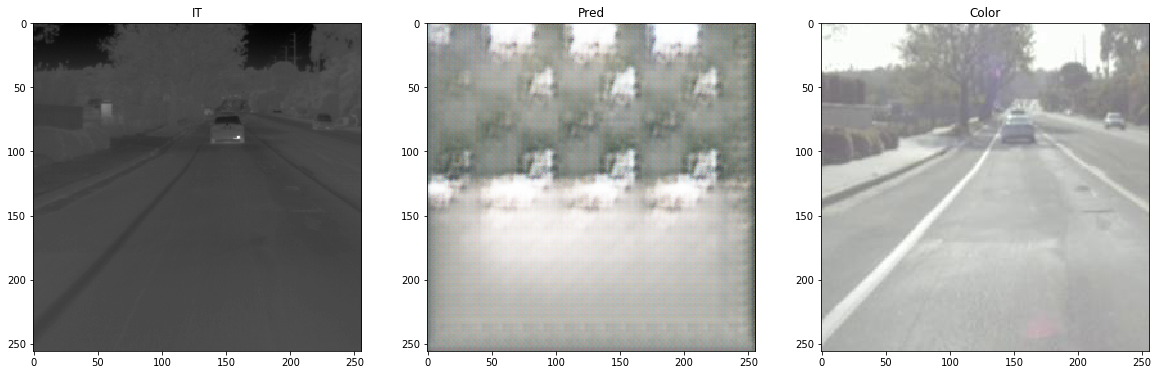

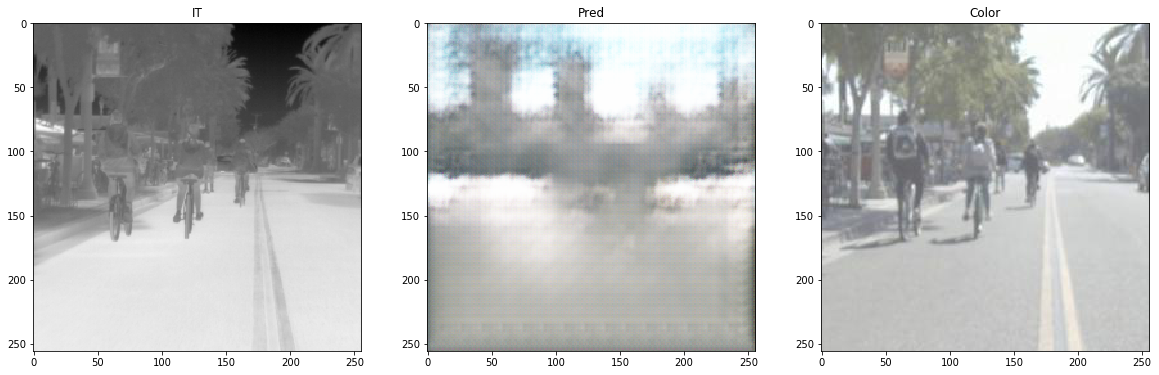

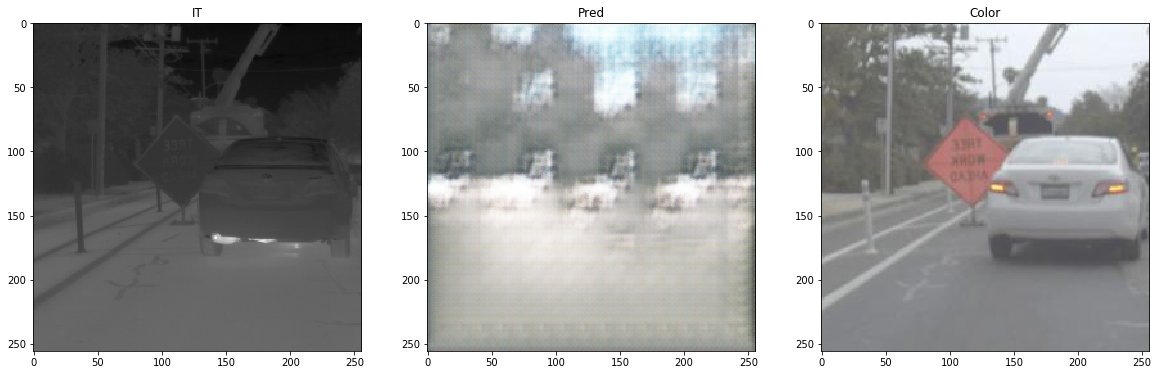

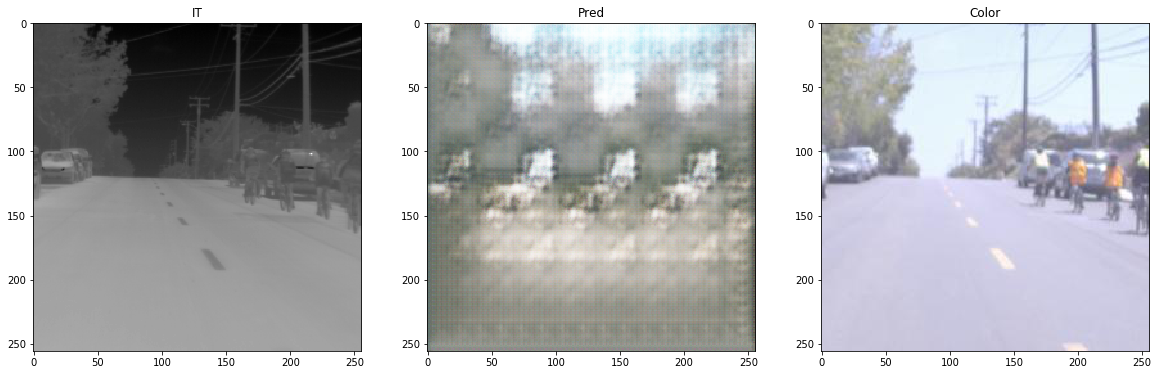

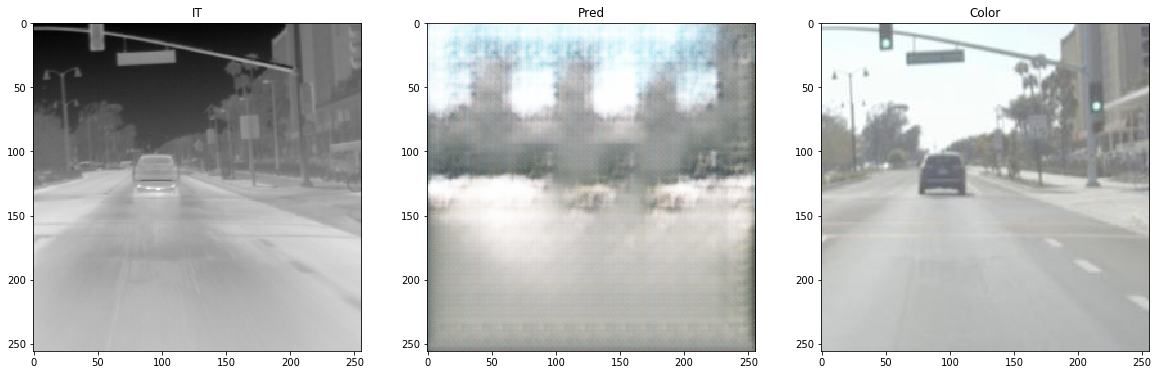

In [38]:
xi = plot_sample(train_crops, g_model)

In [13]:
#g_model.load_weights(weight_name+'/g_model_best_cross_' + weight_name + '.h5')
yimage_generator = image_datagen.flow(y_test, seed=2019, batch_size=8, shuffle=True)
Ximage_generator = image_datagen.flow(X_test, seed=2019, batch_size=8, shuffle=True)

train_generator = zip(Ximage_generator, yimage_generator)
train_crops = crop_generator(train_generator, 256, rand_crop=False)

In [15]:
x2, y2 = next(train_crops)
xi2 = K.constant(x2)
yi2= K.constant(y2)
Xr = K.constant(g_model.predict(x2))
ssimTF = ssim_tf(ssim_fact=1)
# ls = ssimTF(Xr,yi2)
ls=mean_absolute_error(Xr,yi2)
#ls = vgg_loss_bach(Xr, yi2,c_image_shape)
# Y_pred = np.expand_dims(Xr, axis=0)
#res = np.sum(np.sum(K.eval(ls), axis=-1), axis=-1)
v = vgg_obj(1)
a = v(Xr,yi2)
n = binary_crossentropy(yi2, yi2)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    print(n.eval())

#y_true = yi2
#y_pred = Xr
#batch_size = y_true.shape[0];
# ssim_sum = []
# for i in range(batch_size):
#     ssim_sum.append(tf.image.ssim_multiscale(y_true,y_pred,1))

# print(ssim_sum)

[[[0.6398888  0.5707851  0.5666218  ... 0.17016272 0.15603903 0.18338615]
  [0.57403505 0.45871314 0.43969783 ... 0.12381023 0.15603903 0.23090136]
  [0.49832222 0.30032048 0.22986384 ... 0.1152967  0.21965699 0.3282232 ]
  ...
  [0.553143   0.553143   0.553143   ... 0.5345062  0.5345062  0.5345062 ]
  [0.553143   0.553143   0.553143   ... 0.5392876  0.5392876  0.54398227]
  [0.553143   0.553143   0.553143   ... 0.54398227 0.54398227 0.54859096]]

 [[0.66689867 0.66689867 0.6650792  ... 0.15515119 0.15515119 0.15515119]
  [0.6703431  0.66865325 0.6650792  ... 0.15515119 0.15515119 0.15515119]
  [0.6750271  0.67196864 0.66689867 ... 0.15222098 0.15222098 0.15222098]
  ...
  [0.5442159  0.53476715 0.51444465 ... 0.5912877  0.5986071  0.6021535 ]
  [0.5361291  0.53129965 0.5173033  ... 0.5912877  0.5986071  0.60562515]
  [0.52730376 0.52730376 0.53001213 ... 0.6021535  0.6123468  0.6155978 ]]

 [[0.2563302  0.26131675 0.29232863 ... 0.5853606  0.6025694  0.58417284]
  [0.26131675 0.261316

In [23]:

v = vgg_obj(1)

a =vgg_loss_inner(Xr,yi2)

vgg19 = VGG19(include_top=True, weights='imagenet', input_shape=(224,224,3))
# vgg19.trainable = False
# for l in vgg19.layers:
#     l.trainable = False
# model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
# model.trainable = False
vgg19.summary()
# model(yi2)
    
    #return 10*K.mean(K.square(model(y_true) - model(y_pred)))

# with tf.Session() as sess:
#     init = tf.global_variables_initializer()
#     sess.run(init)
#     print(a.eval())
    

574717952/574710816 [==============================] - 54s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_p

In [ ]:
gan_model = define_gan(g_model, d_model, t_image_shape)
g_total, g_cross, g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
X_realA.shape

In [ ]:
n_patch = 16;n_batch = 2
[X_realA, X_realB], y_real = generate_real_samples(train_crops, n_batch, n_patch)
# generate a batch of fake samples
X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
# update discriminator for real samples
d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
# update discriminator for generated samples
d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
# update the generator
g_total, g_cross, g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])

In [33]:
scedual_trainings()

/opt/anaconda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0, d_real[0.187] d_fake[0.045] g_total[24.123] g_cross[4.027] g_loss[0.067] 7.271[sec]
best loss model saved!
model saved...
1, d_real[0.007] d_fake[0.050] g_total[27.252] g_cross[6.004] g_loss[0.071] 0.363[sec]
2, d_real[0.004] d_fake[0.056] g_total[29.954] g_cross[6.484] g_loss[0.078] 0.347[sec]
3, d_real[0.063] d_fake[0.027] g_total[25.344] g_cross[5.021] g_loss[0.068] 0.348[sec]
4, d_real[0.010] d_fake[0.183] g_total[31.545] g_cross[7.231] g_loss[0.081] 0.350[sec]
5, d_real[0.480] d_fake[0.001] g_total[32.779] g_cross[5.147] g_loss[0.092] 0.347[sec]
6, d_real[0.005] d_fake[0.047] g_total[28.525] g_cross[4.788] g_loss[0.079] 0.351[sec]
7, d_real[0.004] d_fake[0.272] g_total[28.897] g_cross[6.961] g_loss[0.073] 0.367[sec]
8, d_real[0.314] d_fake[0.098] g_total[24.427] g_cross[3.768] g_loss[0.069] 0.360[sec]
9, d_real[0.011] d_fake[0.020] g_total[21.869] g_cross[4.532] g_loss[0.058] 0.363[sec]
10, d_real[0.011] d_fake[0.010] g_total[31.913] g_cross[4.959] g_loss[0.090] 0.357[sec]
11, 

93, d_real[0.060] d_fake[0.002] g_total[32.932] g_cross[5.248] g_loss[0.092] 0.359[sec]
94, d_real[0.219] d_fake[0.144] g_total[32.182] g_cross[3.625] g_loss[0.095] 0.362[sec]
95, d_real[0.020] d_fake[0.340] g_total[29.373] g_cross[7.558] g_loss[0.073] 0.358[sec]
96, d_real[0.317] d_fake[0.007] g_total[24.012] g_cross[3.682] g_loss[0.068] 0.359[sec]
97, d_real[0.017] d_fake[0.073] g_total[30.543] g_cross[4.037] g_loss[0.088] 0.358[sec]
98, d_real[0.001] d_fake[0.096] g_total[30.353] g_cross[5.241] g_loss[0.084] 0.356[sec]
99, d_real[0.291] d_fake[0.007] g_total[31.348] g_cross[3.833] g_loss[0.092] 0.353[sec]
100, d_real[0.015] d_fake[0.094] g_total[25.084] g_cross[4.335] g_loss[0.069] 0.350[sec]
101, d_real[0.004] d_fake[0.027] g_total[26.885] g_cross[4.262] g_loss[0.075] 0.348[sec]
102, d_real[0.020] d_fake[0.070] g_total[23.067] g_cross[4.158] g_loss[0.063] 0.345[sec]
103, d_real[0.015] d_fake[0.005] g_total[24.747] g_cross[5.624] g_loss[0.064] 0.342[sec]
104, d_real[0.105] d_fake[0.

ValueError: Input arrays should have the same number of samples as target arrays. Found 4 input samples and 8 target samples.

In [ ]:
dir_name = 'monday_schedualer_18.11'
weight_name = 'L1_(1,1000)w_120e3iter_8b'
# weight_name = 'best_loss_L1_(0,100)w_50e3iter_8b'
d_model = define_discriminator(t_image_shape, c_image_shape)
g_model = define_generator(t_image_shape)
g_model.load_weights(dir_name+'/g_model_' + weight_name + '.h5')
d_model.load_weights(dir_name+'/d_model_' + weight_name + '.h5')

In [ ]:
vec = load(dir_name+'/loss__vgg1_(1,2500)w_1.8e3iter_8b')
plot_loss(vec)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


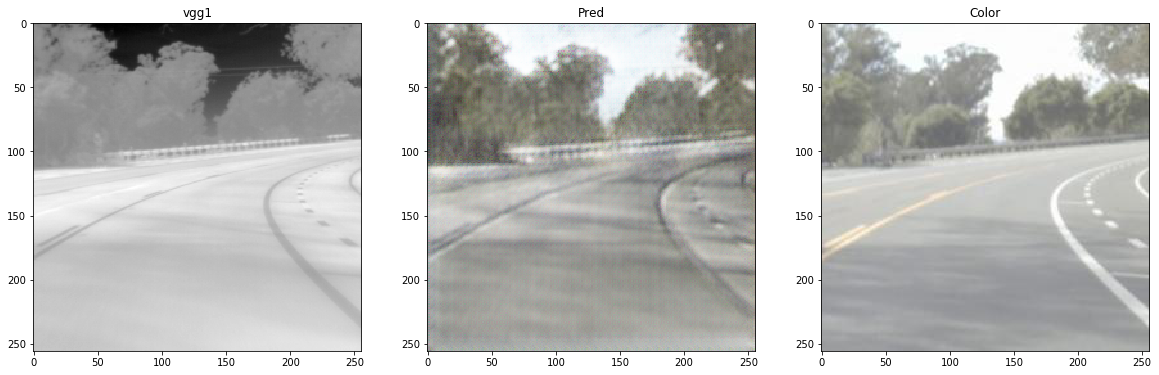

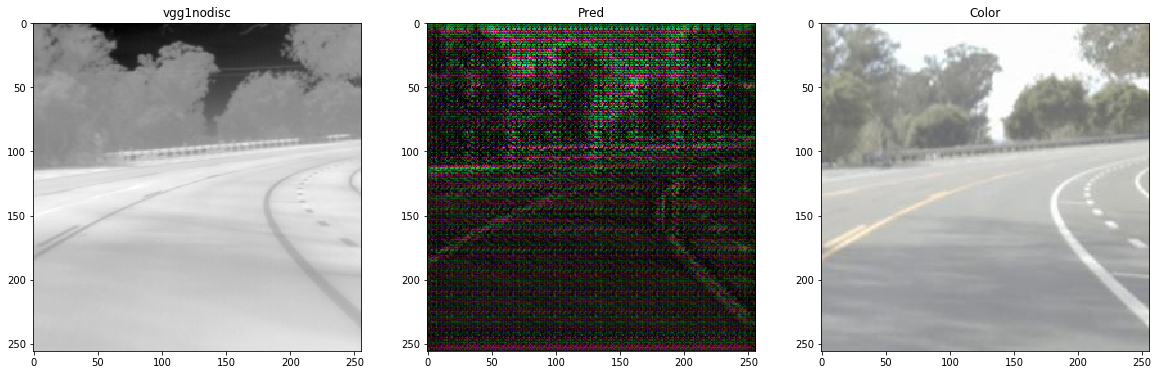

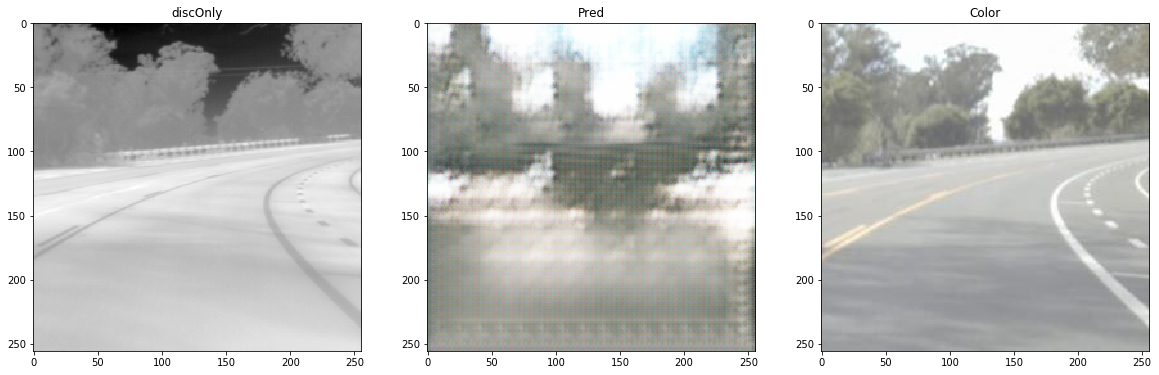

In [42]:
# batch_size = 1
# data_gen_args = dict(horizontal_flip=True)
# image_datagen = ImageDataGenerator(**data_gen_args)        
# yimage_generator = image_datagen.flow(y_train, seed=2019, batch_size=batch_size, shuffle=True)
# Ximage_generator = image_datagen.flow(X_train, seed=2019, batch_size=batch_size, shuffle=True)
# train_generator = zip(Ximage_generator, yimage_generator)
# train_crops = crop_generator(train_generator, 256, rand_crop=False)
# t_image_shape = (256,256,1);c_image_shape = (256,256,3)
# d_model = define_discriminator(t_image_shape, c_image_shape)
# g_model = define_generator(t_image_shape)

# # define the composite model
# gan_model = define_gan(g_model, d_model, t_image_shape)

# dir_name = 'train26.11'
g_names = ['vgg1','vgg1nodisc','discOnly']
plot_compare(g_names, dir_name, g_model, train_crops)

In [ ]:
x = np.zeros((3,3,1,1))
y = np.zeros((3,3,1,1))
ssim = skimage.metrics.structural_similarity
r = ssim(x,y)